In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import shutil
import numpy as np
import pandas as pd
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount('/content/drive')
DRIVE_BASE_PATH = '/content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2'

Mounted at /content/drive


In [ ]:
# Seaview Dataset with Dense Masks from rs_labelled folder
SEAVIEW_RS_IMAGES = os.path.join(DRIVE_BASE_PATH, 'data', 'seaview_mask_labels', 'SEAVIEW_ATL', 'images')
SEAVIEW_RS_MASKS = os.path.join(DRIVE_BASE_PATH, 'data', 'seaview_mask_labels', 'SEAVIEW_ATL', 'masks')
SEAVIEW_RS_FULL_MASKS = os.path.join(DRIVE_BASE_PATH, 'data', 'seaview_mask_labels', 'SEAVIEW_ATL', 'masks_stitched')

In [ ]:
# Seaview Dataset with Point Labels (Sparse)
SEAVIEW_PL_IMAGES = os.path.join(DRIVE_BASE_PATH, 'data', 'benthic_datasets', 'seaview_point_labels')
SEAVIEW_PL_LABELS = os.path.join(DRIVE_BASE_PATH, 'data', 'benthic_datasets', 'seaview_point_labels', 'tabular-data')
REGIONS = {
    1: 'ATL', 2: 'IND_CHA', 3: 'IND_MDV', 4: 'PAC_AUS', 5: 'PAC_USA',
    6: 'PAC_IDN_PHL', 7: 'PAC_SLB', 8: 'PAC_TWN', 9: 'PAC_TLS',
    }

In [ ]:
# Taking full masks as target labels
sample_targets = os.listdir(SEAVIEW_RS_FULL_MASKS)[:10]
sample_targets

['17001739002_mask.png',
 '17001739702_mask.png',
 '17001738502_mask.png',
 '17001739802_mask.png',
 '17001738602_mask.png',
 '17001739502_mask.png',
 '17001740102_mask.png',
 '17001740202_mask.png',
 '17001738902_mask.png',
 '17001740402_mask.png']

In [ ]:
img = cv2.imread(os.path.join(SEAVIEW_RS_FULL_MASKS, sample_targets[0]))
np.unique(img)
print(sample_targets[0])
# cv2_imshow(img)

array([  0, 255], dtype=uint8)

In [ ]:
# Taking unstitched masks as predicted labels
c = 0
sample_preds = ['17001739002_mask.png',
 '17001739702_mask.png',
 '17001738502_mask.png',
 '17001739802_mask.png',
 '17001738602_mask.png',
 '17001739502_mask.png',
 '17001740102_mask.png',
 '17001740202_mask.png',
 '17001738902_mask.png',
 '17001740402_mask.png']
sample_preds = [f'{i[:-4]}_0{i[-4:]}' for i in sample_preds]

In [ ]:
img2 = cv2.imread(os.path.join(SEAVIEW_RS_MASKS, sample_preds[0]))
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# cv2_imshow(img2)

In [ ]:
def visualize_output(title, image_path, mask_path, pred_path, input_data='Dense Mask'):
    image = cv2.imread(image_path)
    mask_gt = cv2.imread(mask_path)
    pred_rgb = cv2.imread(pred_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_gt = cv2.cvtColor(mask_gt, cv2.COLOR_BGR2RGB)
    pred_rgb = cv2.cvtColor(pred_rgb, cv2.COLOR_BGR2RGB)


    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    ax[0].imshow(image)
    ax[0].set_title(f"{title}")
    ax[1].imshow(mask_gt)
    ax[1].set_title("GT Mask (reef_support)")
    ax[2].imshow(pred_rgb)
    ax[2].set_title(f"Superpixels w {input_data}")
    plt.show()

# one hot encoding of ground truth color
one_hot_mapping = {0: [0, 0, 0], 1: [255, 0, 0], 2: [0, 0, 255]}
def get_ohe_mask(mask, color_mapping):
    mask_ohe = np.zeros(mask.shape)
    for label, color in one_hot_mapping.items():
        mask_ohe[np.all(mask == color, axis=-1), :] = label
    return mask_ohe

# mask_ohe_pred = get_ohe_mask(img2, one_hot_mapping)
# mask_ohe_target = get_ohe_mask(img, one_hot_mapping)

In [ ]:
# Evaluation metrics
pa_metric = torchmetrics.Accuracy(task="multiclass", num_classes = 3, ignore_index=3)
mpa_metric = torchmetrics.Accuracy(task="multiclass", num_classes = 3, ignore_index=3, average='macro')
iou_metric = torchmetrics.JaccardIndex(task="multiclass", num_classes = 3, ignore_index=3, average='none')

Sample           : 17001739002_mask.png
GT Mask: Shape: (1031, 1031, 3)
0: (array([0., 1., 2.]), array([764670, 113071, 185220]))
1: (array([0., 1., 2.]), array([764670, 113071, 185220]))
2: (array([0., 1., 2.]), array([764670, 113071, 185220]))
Prediction: Shape: (1031, 1031, 3)
0: (array([0., 2.]), array([1026336,   36625]))
1: (array([0., 2.]), array([1026336,   36625]))
2: (array([0., 2.]), array([1026336,   36625]))
PA               : 0.7538329362869263
PA (Class Wise)  : 0.399245947599411
IoU (Class Wise) : tensor([0.7450, 0.0000, 0.1977])


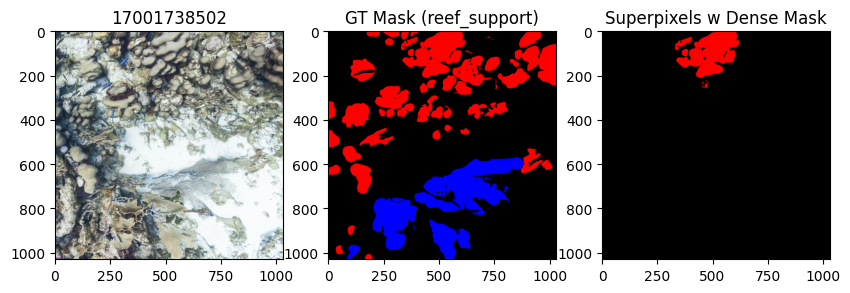

AttributeError: ignored

In [ ]:
for i, pred in enumerate(sample_preds):
    image_path = os.path.join(SEAVIEW_RS_IMAGES, '.'.join([sample_targets[i].split('_')[0], 'jpg']))
    gt_path = os.path.join(SEAVIEW_RS_FULL_MASKS, sample_targets[i])
    label_path = os.path.join(SEAVIEW_RS_MASKS, pred)

    gt_mask = cv2.imread(gt_path)
    propagated_labels = cv2.imread(label_path)
    gt_mask = get_ohe_mask(gt_mask, one_hot_mapping)
    propagated_labels = get_ohe_mask(propagated_labels, one_hot_mapping)

    gt_mask_torch = torch.from_numpy(gt_mask[:,:,0])
    propagated_labels_torch = torch.from_numpy(propagated_labels[:,:,0])
    sample_accuracy = pa_metric(propagated_labels_torch, gt_mask_torch)
    sample_accuracy_class_wise = mpa_metric(propagated_labels_torch, gt_mask_torch)
    sample_iou_class_wise = iou_metric(propagated_labels_torch, gt_mask_torch)

    print(f"Sample           : {sample_targets[i]}")
    print(f"GT Mask: Shape: {gt_mask.shape}")
    for i in range(gt_mask.shape[-1]):
        print(f"{i}: {np.unique(gt_mask[:,:,i], return_counts=True)}")
    print(f"Prediction: Shape: {propagated_labels.shape}")
    for i in range(propagated_labels.shape[-1]):
        print(f"{i}: {np.unique(propagated_labels[:,:,i], return_counts=True)}")
    print(f"PA               : {sample_accuracy.item()}")
    print(f"PA (Class Wise)  : {sample_accuracy_class_wise}")
    print(f"IoU (Class Wise) : {sample_iou_class_wise}")
    visualize_output(sample_targets[i].split('_')[0], image_path, gt_path, label_path, input_data='Dense Mask')

In [ ]:
sample_accuracy

tensor(0.7538)

In [ ]:
wpropagated_labels_torch

tensor([[255, 255, 255,  ...,   0,   0,   0],
        [255, 255, 255,  ...,   0,   0,   0],
        [255, 255, 255,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]], dtype=torch.uint8)